# zer0C4 -- a crypto challenge from 0CTF 2018
(solved by szabolor)

## Modified RC4-32 cipher

We were given a slightly modified version of an RC4 cipher which operates on a reduced modulo of 32. The important difference of the conventional RC4 cipher can be found at the initialization function (`ksa`): the counter `i` start from 1 instead of 0!

The server-side software generates a secret key and then let the client (you) to try 512\*1500=768000 pieces of 16 byte data key XOR-ed with its secret key as a new cipher. After that you must guess the secret key that the server used.

Mostly what I have done is more or less "exploratory data analysis" based on the correlation of the key and the first two output bytes. But thanks God, it seemed to be worked :)

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

import os
import binascii

N = 5
m = (1 << N)
mask = (1 << N) - 1
klen = 16

def ksa(key):
	"""Key-scheduling algorithm for 0ops Cipher 4"""
	s = list(range(1 << N))
	i = 0
	j = 0
	while 1:
		i = (i + 1) & mask  # <<< Note the starting value of i=1 (!)
		j = (j + s[i] + key[i%len(key)]) & mask
		s[i], s[j] = s[j], s[i]
		if not i:
			break
	return s

def prga(s, n):
	"""Pseudo-random generation algorithm for 0ops Cipher 4"""
	i = 0
	j = 0
	res = bytearray()
	for _ in range(n):
		i = (i + 1) & mask
		j = (j + s[i]) & mask
		s[i], s[j] = s[j], s[i]
		res.append(s[(s[i]+s[j])&mask])
	return res

## key[1] and key[2] recovery

As previously observed[1] the first byte of the pseudorandom stream may have some degree of correlation with a very limited part of the keystream. Roos's observation was based on the conventional RC4 cipher, where the state generation counter starts with 0, but his idea could easly adapted for this case. Since the first state byte touched by the key value is just shifted by one, the most probably values comes with in a shifted expression:
$$ s[E] = \sum_{i=1}^E k[i] + \frac{E(E+1)}{2} $$
That gives $ s[1] = k[1] + 1 $ and $ s[2] = k[1] + k[2] + 3 $ with high probability.

The following script checks the empirical probabilities of this hypothesis for the first few state bytes.

[1]: https://netfuture.ch/1995/09/weak-keys-in-rc4/ (1995-09-22 by Andrew Roos)

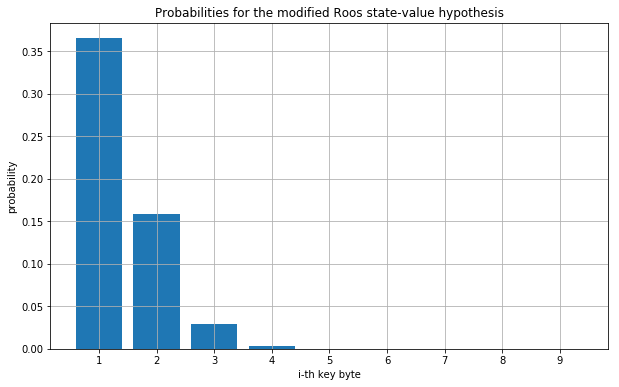

In [2]:
count = 10000
hip_table = []
end_idx = 10
for idx in range(1, end_idx):
    hip = 0;
    for i in range(count):
        key = list(map(lambda x: x & 31, os.urandom(16)))
        test = sum(key[1:idx+1]) + idx*(idx+1) // 2
        res = ksa(key)
        
        if res[idx] == test: 
            hip += 1

    hip_table.append(hip/float(count))

plt.figure(figsize=(10, 6))
plt.grid()
plt.xticks(range(1, end_idx))
plt.xlabel("i-th key byte")
plt.ylabel("probability")
plt.title("Probabilities for the modified Roos state-value hypothesis")
plt.bar(range(1, end_idx), hip_table);

It can be clearly see, that the probability values are way worse that Roos's ones, (maybe) due to the reduced state-space. But it does work for the first key value at least with around 1/3 chance!

At the first pseudorandom byte generation the $ s[s[1]+s[s[1]]] $ is returned, and -- continuing Roos's idea -- let's make that value equals with $ s[2] $ with a high probability. That could mean to use $s[1] = 1$, and from that $k[1] = 0$ follows. So finally if we get $s[2]$ that would actually mean (with a relatively high probability) $k[1]+k[2]+3 = k[2]+3$. That shows us the strong connection of the first prng byte and the 3rd byte of the key.

The next script test for some correlation of $k[0]$ and $k[1]$, looking at the distribution of the $b[0]$ values and also checks the previous $b[0] == k[2] + 3$ hypothesis experimentally.

In [3]:
count = 512
crest_table=[]
hip_table=[]
for key_1 in range(32):
    crest_row = []
    hip_row = []
    for key_2 in range(32):
        stat = {}
        hip = 0
        for _ in range(count):
            key = list(map(lambda x: x & mask, os.urandom(16)))
            key[1] = key_1
            key[2] = key_2

            state = ksa(key)
            res = prga(state, 16)

            if res[0] in stat:
                stat[res[0]] += 1
            else:
                stat[res[0]] = 1
            
            if res[0] == ((key[2]+3) % m):
                hip += 1

        sorted_stat = sorted(stat, key=stat.get, reverse=True)
        crest_factor = stat[sorted_stat[0]] / float(stat[sorted_stat[1]])
        crest_row.append(crest_factor)
        hip_row.append(hip)
        #print("key[2]=%d, crest factor: %.4f" % (key_2, crest_factor))
    crest_table.append(crest_row)
    hip_table.append(hip_row)

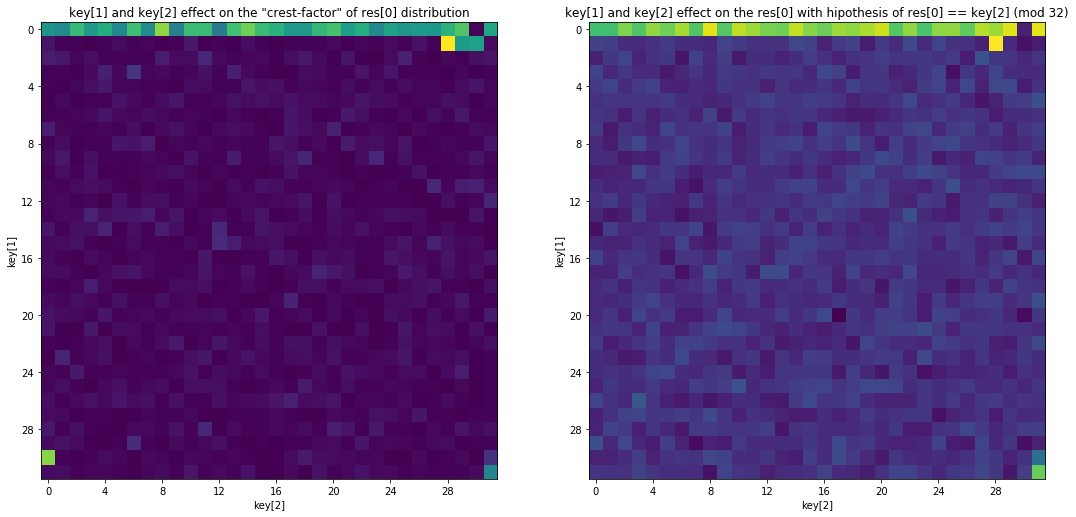

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(18, 9)
ax1.imshow(crest_table)
ax1.set_xlabel("key[2]")
ax1.set_ylabel("key[1]")
ax1.set_xticks(range(0, m, 4))
ax1.set_yticks(range(0, m, 4))
ax1.set_title("key[1] and key[2] effect on the \"crest-factor\" of res[0] distribution")
ax2.imshow(hip_table)
ax2.set_xlabel("key[2]")
ax2.set_ylabel("key[1]")
ax2.set_xticks(range(0, m, 4))
ax2.set_yticks(range(0, m, 4))
ax2.set_title("key[1] and key[2] effect on the res[0] with hipothesis of res[0] == key[2] (mod 32)");

Thus we can see, for $k[1]=0$, $b[0] = k[2] + 3$ holds for a _significant_ probability! (note that with $k[2] = 30$ this hypothesis does not work - that is 1/32 chance). Furthermore there is less chance to meet the hypothesis outside of $k[1]=0$.

That means one can guess with a good probability the $k[1]$ and $k[2]$ values based on observing the $b[0]$ distribution looking for highly frequent elements.

## key[3..15] recovery

So far we learned a correlation of $b[0]$ and $k[1], k[2]$. Thus it seems to be natural to observe the next prng output byte. (Well, this is my best justifing why I began to search for patterns at $b[1]$, although $b[1]$ isn't specifically considered in the papers I have read). The following observations came after experimenting with random keys where $k[1]$ and $k[2]$ was fixed. (So again, this is a typical "left as an exercise to the reader" situation -- sorry)

The idea: what if $k[1] + k[2] \equiv 29\ (\textrm{mod}\ 32)$?

As we noted at the beginning, at the most probably situation is $s[1] = 1+k[1]$ and $s[2] = 3+k[1]+k[2]$. So $k[1] + k[2] \equiv 29\ (\textrm{mod}\ 32)$ means, that $s[2] = 0$.

Let's go through the two steps of prng generation:

1st round
- $i=1$ and $j=s[1]=1+k[1]$
- $\textrm{swap}(s[1], s[1+k[1]])$
-  $\implies\ s[1+k[1]] = 1+k[1]$

2nd round
- $i=2$ and $j=1+k[1]+s[2]=1+k[1]$
- $\textrm{swap}(s[2], s[1+k[1]])$
-  $\implies\ s[1+k[1]] = 0$ and $s[2] = 1+k[1]$

Finally the 2nd round return $b[1]=s[s[2]+s[1+k[1]]] = s[1+k[1]+0]=s[1+k[1]]=0$. So we can conclude that with $k[1] + k[2] \equiv 29\ (\textrm{mod}\ 32)$ condition $b[1] = 0$ holds with _high_ probability.

But $b[1]=0$ only holds if $s[2]=0$ and $s[2]=0$ is true if something else does not swap values at the key scheduling for $i>2$. For example we can force for $i=3$ to be swapped by $s[2]$ and thus there is a high chance for $s[2]\not=0$. At the end of 2nd round $j=0$ (because we probably swapped last with 0 to get $s[2]=0$), so for the 3rd round $j = s[3]+k[3]=3+k[3]$. As we want to have $j=2\implies k[3]=31$.

What is it mean in terms of finding the right key? Well, we can try for a fixed $k[1],k[2]$ all the 32 combinations of $k[3]$ (with randomized others parts) and watch for the distribution of $b[1]$: if it has a low "crest-factor", then it  means we found the $k[3]=31$ state. It is not obvious to set directly this state because of the XOR secret key, so after finding a fixed value, we immediately got the secret key as well.

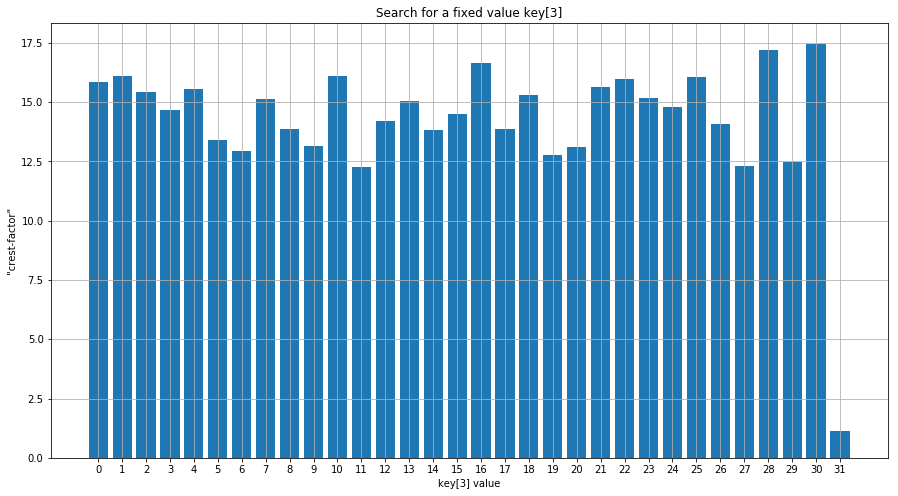

In [5]:
count = 1000
crest_row = []
for key_3 in range(32):
    stat = {}
    hip = 0
    for _ in range(count):
        key = list(map(lambda x: x & mask, os.urandom(16)))
        key[1] = 12 # e.g. 12+17 = 29
        key[2] = 17
        key[3] = key_3

        state = ksa(key)
        res = prga(state, 16)

        if res[1] in stat:
            stat[res[1]] += 1
        else:
            stat[res[1]] = 1

    sorted_stat = sorted(stat, key=stat.get, reverse=True)
    crest_factor = stat[sorted_stat[0]] / float(stat[sorted_stat[1]])
    crest_row.append(crest_factor)
    #print("key[2]=%d, crest factor: %.4f" % (key_3, crest_factor))

plt.figure(figsize=(15, 8))
plt.grid()
plt.xticks(range(32))
plt.xlabel("key[3] value")
plt.ylabel("\"crest-factor\"")
plt.title("Search for a fixed value key[3]")
plt.bar(range(32), crest_row);

Now fix the $k[3]$ value as well, since this less frequent occurance depends on the key positions preceeding the interesting key. Let's just randomly select a value for the range where $s[2]=0$ meets, so strictly not the currently found _detection value_.

In [6]:
count = 1000
crest_threshold = 5
known_keys=[12, 17]

for key_idx in list(range(3, 16)):
    #print("processing key[%d]" % (key_idx))
    detection = -1;
    crest_min_counter = 0;

    for new_key in range(32):
        stat = {}

        for i in range(count):
            key = list(map(lambda x: x & 31, os.urandom(16)))

            key[1:key_idx] = known_keys
            key[key_idx] = new_key
            state = ksa(key)
            res = prga(state, 16)

            if res[1] in stat:
                stat[res[1]] += 1
            else:
                stat[res[1]] = 1

        sorted_stat = sorted(stat, key=stat.get, reverse=True)
        crest = stat[sorted_stat[0]] / float(stat[sorted_stat[1]])
        #print("key[%d]: iter=%d crest=%.4f" % (key_idx, new_key, crest))
        #print("diff:", [(x, stat[x]) for x in sorted_stat][:5])

        if crest < crest_threshold:
            crest_min_counter += 1;
            detection = new_key

    if crest_min_counter == 1:
        #print("key[%d] detector at: %d" % (key_idx, detection))
        known_keys.append((detection - 1) % 32) # just select a non-detector value
    else:
        print("No or more than one crest min at key[%d]" % (key_idx))
        break
        
print("Keys to try iteratively (without key[0]!): ", known_keys)
print("Detection fixed values (for key[3..15]): ", list(map(lambda x: (x+1)&mask, known_keys[2:])))

Keys to try iteratively (without key[0]!):  [12, 17, 30, 28, 27, 26, 25, 24, 23, 22, 21, 20, 31, 18, 17]
Detection fixed values (for key[3..15]):  [31, 29, 28, 27, 26, 25, 24, 23, 22, 21, 0, 19, 18]


So using the detection fixed values at the given key index, one can found the XOR-ed original secret key byte.

Finally this way we can gain every byte of the secret key except the first. Well, just simply brute force it! We can brute-force more, if we afraid of the network delays/slowness. (I was brute-forcing 3 indexes, and it wasn't noticable at all!)

## Local zer0C4 attack

In [7]:
import os

N = 5
mask = (1 << N) - 1
klen = 16

def ksa(key):
	"""Key-scheduling algorithm for 0ops Cipher 4"""
	s = list(range(1 << N))
	i = 0
	j = 0
	while 1:
		i = (i + 1) & mask
		j = (j + s[i] + key[i%len(key)]) & mask
		s[i], s[j] = s[j], s[i]
		if not i:
			break
	return s

def prga(s, n):
	"""Pseudo-random generation algorithm for 0ops Cipher 4"""
	i = 0
	j = 0
	res = bytearray()
	for _ in range(n):
		i = (i + 1) & mask
		j = (j + s[i]) & mask
		s[i], s[j] = s[j], s[i]
		res.append(s[(s[i]+s[j])&mask])
	return res


def gen_stream(modifier):
	current_key = [ii^jj for ii,jj in zip(key, modifier)]
	return prga(ksa(current_key), 16)


def solve():
	crest_threshold_counter = 0
	count = 512

	for new_key in range(32):
		# attacking key[1] and key[2]
		stat = {}
		for _ in range(count):
			modifier = list(map(lambda x: x & 31, os.urandom(16)))
			modifier[1] = new_key
			modifier[2] = 0 # fix, no to change (thus not to generate "noise")
			res = gen_stream(modifier)

			if res[0] in stat:
				stat[res[0]] += 1
			else:
				stat[res[0]] = 1

		sorted_stat = sorted(stat, key=stat.get, reverse=True)
		crest = stat[sorted_stat[0]] / float(stat[sorted_stat[1]])
		#print("key[%d]: iter=%d crest=%.4f" % (1, new_key, crest))

		if crest > 2:
			crest_threshold_counter += 1;
			key_1 = new_key
			key_2 = (sorted_stat[0] - 3) % 32

	if crest_threshold_counter == 1:
		print("key[1]=%d, key[2]=%d" % (key_1, key_2))
	else:
		print("no or more than one detection!")
		print("roll the dice again ;)")

	# attack from key[3] to key[13]
	recovered_key = [key_1, key_2]
	probe_keys = [12, 17, 30, 28, 27, 26, 25, 24, 23, 22, 21, 20, 31, 18, 17]
	detectors =  [ 0,  0, 31, 29, 28, 27, 26, 25, 24, 23, 22, 21,  0, 19, 18]

	for key_idx in range(3, 13+1):
		print("processing key[%d]" % (key_idx))
		detection = -1;
		crest_min_counter = 0;

		for new_key in range(32):

			stat = {}
			for i in range(count):
				modifier = list(map(lambda x: x & 31, os.urandom(16)))
				# now we have to xor with the already found keys in order to have control
				modifier[1:key_idx] = [i^j for i, j in zip(probe_keys, recovered_key)]
				modifier[key_idx] = new_key
				res = gen_stream(modifier)
				
				if res[1] in stat:
					stat[res[1]] += 1
				else:
					stat[res[1]] = 1

			sorted_stat = sorted(stat, key=stat.get, reverse=True)
			crest = stat[sorted_stat[0]] / float(stat[sorted_stat[1]])
			#print("key[%d]: iter=%d crest=%.4f" % (key_idx, new_key, crest))

			if crest < 5:
				crest_min_counter += 1;
				detection = new_key

		if crest_min_counter == 1:
			print("key[%d] detector at: %d" % (key_idx, detection))
			recovered_key.append((detection ^ detectors[len(recovered_key)]) % 32)
			#print("known xorkey so far:", recovered_key)
		else:
			print("No or more than one crest min at key[%d]" % (key_idx))
			break

	# key[0] és key[14], key[15] local brute force attack
	# this is because network traffic thought to be slow
	for key_0 in range(32):
		for key_14 in range(32):
			for key_15 in range(32):
				modifier = [0]*16
				modifier[0] = key_0
				modifier[1:14] = recovered_key
				modifier[14] = key_14
				modifier[15] = key_15
				if allzero == gen_stream(modifier):
					sol = [key_0] + recovered_key + [key_14, key_15]
					return sol


allzero = prga(ksa([0]*16), 16)
key = list(map(lambda x: x & 31, os.urandom(16)))
print("secret key to be guessed:", key)
guessed_key = solve()
print(guessed_key)
print("This is the same? >",guessed_key == key)

secret key to be guessed: [0, 28, 5, 12, 9, 8, 21, 30, 2, 20, 2, 0, 4, 3, 18, 9]
key[1]=28, key[2]=5
processing key[3]
key[3] detector at: 19
processing key[4]
key[4] detector at: 20
processing key[5]
key[5] detector at: 20
processing key[6]
key[6] detector at: 14
processing key[7]
key[7] detector at: 4
processing key[8]
key[8] detector at: 27
processing key[9]
key[9] detector at: 12
processing key[10]
key[10] detector at: 21
processing key[11]
key[11] detector at: 22
processing key[12]
key[12] detector at: 17
processing key[13]
key[13] detector at: 3
[0, 28, 5, 12, 9, 8, 21, 30, 2, 20, 2, 0, 4, 3, 18, 9]
This is the same? > True


Notes:
- the current implementation uses 512 probes per index per values, so altogether less than 200000 message used (~100000 on average)
- the _high probability_ expression here only refers to an experimentally guessed metric, further analysis should be performed on the topic!
- at the challenge we faced other infrastuctural issues, such as the key at the server doen't remained the original secret key, instead it saved the previous XOR-ed form (thanks to @ngg for his kind help)
- for the server multiple key had to be collected; maximal batch size was 512 (also thanks to @ngg)